<a href="https://colab.research.google.com/github/kim-kidong/hello-world/blob/master/0920_gg_101_%E1%84%80%E1%85%B5%E1%84%80%E1%85%A8%E1%84%87%E1%85%A5%E1%86%AB%E1%84%8B%E1%85%A7%E1%86%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl http://www.manythings.org/anki/kor-eng.zip -o kor-eng.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25348  100 25348    0     0  71202      0 --:--:-- --:--:-- --:--:-- 71202


In [2]:
!ls

kor-eng.zip  sample_data


In [3]:
!unzip kor-eng.zip

Archive:  kor-eng.zip
  inflating: _about.txt              
  inflating: kor.txt                 


In [4]:
!head -10 kor.txt

Who?	누구?
Hello!	안녕!
No way!	절대 아니야.
No way!	그럴리가!
Goodbye!	안녕!
I'm sad.	슬퍼.
Me, too.	나도.
Perfect!	완벽해!
Shut up!	시끄러워!
Welcome.	어서오세요.


In [0]:
# Deep Learning Quick Reference Chapter 11: Seq2Seq
# Mike Bernico <mike.bernico@gmail.com>
# This program expects english to french sentance pairs located in chapter_11/data/
# Dataset can be found at http://www.manythings.org/anki/fra-eng.zip

from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.callbacks import TensorBoard
import numpy as np
import os
from pathlib import Path


def load_data(num_samples=50000, start_char='\t', end_char='\n', data_path='kor.txt'):
    input_texts = []
    target_texts = []
    input_characters = set()
    target_characters = set()
    lines = open(Path(data_path), 'r', encoding='utf-8').read().split('\n')
    for line in lines[: min(num_samples, len(lines) - 1)]:
        input_text, target_text = line.split('\t')
        target_text = start_char + target_text + end_char
        input_texts.append(input_text)
        target_texts.append(target_text)
        for char in input_text:
            if char not in input_characters:
                input_characters.add(char)
        for char in target_text:
            if char not in target_characters:
                target_characters.add(char)

    input_characters = sorted(list(input_characters))
    target_characters = sorted(list(target_characters))
    num_encoder_tokens = len(input_characters)
    num_decoder_tokens = len(target_characters)
    max_encoder_seq_length = max([len(txt) for txt in input_texts])
    max_decoder_seq_length = max([len(txt) for txt in target_texts])

    print('Number of samples:', len(input_texts))
    print('Number of unique input tokens:', num_encoder_tokens)
    print('Number of unique output tokens:', num_decoder_tokens)
    print('Max sequence length for inputs:', max_encoder_seq_length)
    print('Max sequence length for outputs:', max_decoder_seq_length)
    return {'input_texts': input_texts, 'target_texts': target_texts,
            'input_chars': input_characters, 'target_chars': target_characters,
            'num_encoder_tokens': num_encoder_tokens, 'num_decoder_tokens': num_decoder_tokens,
            'max_encoder_seq_length': max_encoder_seq_length, 'max_decoder_seq_length': max_decoder_seq_length}


def one_hot_vectorize(data):
    input_chars = data['input_chars']
    target_chars = data['target_chars']
    input_texts = data['input_texts']
    target_texts = data['target_texts']
    max_encoder_seq_length = data['max_encoder_seq_length']
    max_decoder_seq_length = data['max_decoder_seq_length']
    num_encoder_tokens = data['num_encoder_tokens']
    num_decoder_tokens = data['num_decoder_tokens']

    input_token_index = dict([(char, i) for i, char in enumerate(input_chars)])
    target_token_index = dict([(char, i) for i, char in enumerate(target_chars)])
    encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32')
    decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
    decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

    for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
        for t, char in enumerate(input_text):
            encoder_input_data[i, t, input_token_index[char]] = 1.
        for t, char in enumerate(target_text):
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_input_data[i, t, target_token_index[char]] = 1.
            if t > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    data['input_token_index'] = input_token_index
    data['target_token_index'] = target_token_index
    data['encoder_input_data'] = encoder_input_data
    data['decoder_input_data'] = decoder_input_data
    data['decoder_target_data'] = decoder_target_data
    return data


def build_models(lstm_units, num_encoder_tokens, num_decoder_tokens):
    # train model
    encoder_input = Input(shape=(None, num_encoder_tokens), name='encoder_input')
    encoder_outputs, state_h, state_c = LSTM(lstm_units, return_state=True, name="encoder_lstm")(encoder_input)
    encoder_states = [state_h, state_c]

    decoder_input = Input(shape=(None, num_decoder_tokens), name='decoder_input')
    decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True,
                                 name="decoder_lstm")
    decoder_outputs, _, _ = decoder_lstm(decoder_input, initial_state=encoder_states)
    decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='softmax_output')
    decoder_output = decoder_dense(decoder_outputs)

    model = Model([encoder_input, decoder_input], decoder_output)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

    encoder_model = Model(encoder_input, encoder_states)

    decoder_state_input_h = Input(shape=(lstm_units,))
    decoder_state_input_c = Input(shape=(lstm_units,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_input, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model(
        [decoder_input] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)

    return model, encoder_model, decoder_model


def create_callbacks(name):
    tensorboard_callback = TensorBoard(log_dir=os.path.join(os.getcwd(), "tb_log_char_s2s", name),
                                       write_graph=True,
                                       write_grads=False)
    return [tensorboard_callback]


Using TensorFlow backend.


Number of samples: 909
Number of unique input tokens: 69
Number of unique output tokens: 662
Max sequence length for inputs: 124
Max sequence length for outputs: 54
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, None, 69)     0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      (None, None, 662)    0                                            
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(None, 256), (None, 333824      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(None, Non

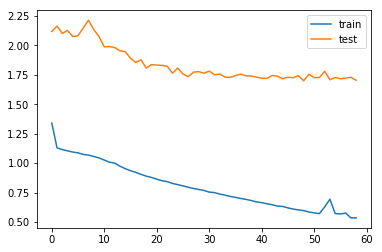

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer decoder_lstm was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder_lstm_9/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'encoder_lstm_9/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer decoder_lstm was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'input_11:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'input_12:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [0]:
from keras.callbacks import EarlyStopping
from matplotlib import pyplot

data = load_data()
data = one_hot_vectorize(data)
# callbacks = create_callbacks("char_s2s")
model, encoder_model, decoder_model = build_models(256, data['num_encoder_tokens'], data['num_decoder_tokens'])
print(model.summary())


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)


history = model.fit(x=[data["encoder_input_data"], data["decoder_input_data"]],
          y=data["decoder_target_data"],
          batch_size=64,
          epochs=400,
          validation_split=0.2,
          callbacks=[es])
#           callbacks=callbacks)

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

model.save('char_s2s_train.h5')
encoder_model.save('char_s2s_encoder.h5')
decoder_model.save('char_s2s_decoder.h5')

In [0]:
!ls

_about.txt	     char_s2s_train.h5	kor-eng.zip  tb_log_char_s2s
char_s2s_decoder.h5  fra-eng.zip	kor.txt
char_s2s_encoder.h5  fra.txt		sample_data


In [0]:
from keras.models import Model, load_model
# from train_char_seq2seq import load_data, one_hot_vectorize
import numpy as np


def load_models():
    model = load_model('char_s2s_train.h5')
    encoder_model = load_model('char_s2s_encoder.h5')
    decoder_model = load_model('char_s2s_decoder.h5')
    return [model, encoder_model, decoder_model]


def decode_sequence(input_seq, data, encoder_model, decoder_model):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, data['num_decoder_tokens']))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, data['target_token_index']['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = data["reverse_target_char_index"][sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > data['max_decoder_seq_length']):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, data['num_decoder_tokens']))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


def create_reverse_indicies(data):
    data['reverse_input_char_index'] = dict(
        (i, char) for char, i in data["input_token_index"].items())
    data['reverse_target_char_index'] = dict(
        (i, char) for char, i in data["target_token_index"].items())
    return data


In [0]:
data = load_data()
data = one_hot_vectorize(data)
data = create_reverse_indicies(data)
model, encoder_model, decoder_model = load_models()

for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = data["encoder_input_data"][seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq, data, encoder_model, decoder_model)
    print('-')
    print('Input sentence:', data['input_texts'][seq_index])
    print('Correct Translation:', data['target_texts'][seq_index].strip("\t\n"))
    print('Decoded sentence:', decoded_sentence)

Number of samples: 909
Number of unique input tokens: 69
Number of unique output tokens: 662
Max sequence length for inputs: 124
Max sequence length for outputs: 54


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


-
Input sentence: Who?
Correct Translation: 누구?
Decoded sentence: 좋아하는 가수는 누구예요?

-
Input sentence: Hello!
Correct Translation: 안녕!
Decoded sentence: 우리는 톰과 즐거운 시간을 가졌다.

-
Input sentence: No way!
Correct Translation: 절대 아니야.
Decoded sentence: 나도 너랑 같은 처지야.

-
Input sentence: No way!
Correct Translation: 그럴리가!
Decoded sentence: 나도 너랑 같은 처지야.

-
Input sentence: Goodbye!
Correct Translation: 안녕!
Decoded sentence: 우리는 그 사건을 검토할 필요가 있다.

-
Input sentence: I'm sad.
Correct Translation: 슬퍼.
Decoded sentence: 나도 너랑 같은 처지야.

-
Input sentence: Me, too.
Correct Translation: 나도.
Decoded sentence: 그건 무슨 언어였지?

-
Input sentence: Perfect!
Correct Translation: 완벽해!
Decoded sentence: 이게 대체 뭐예요?

-
Input sentence: Shut up!
Correct Translation: 시끄러워!
Decoded sentence: 우리는 그 사건을 검토할 필요가 있다.

-
Input sentence: Welcome.
Correct Translation: 어서오세요.
Decoded sentence: 거짓말 하지 마세요.

-
Input sentence: Welcome.
Correct Translation: 환영합니다.
Decoded sentence: 거짓말 하지 마세요.

-
Input sentence: Cheer up!
Correct Translat

In [0]:
data = load_data()
data = one_hot_vectorize(data)
data = create_reverse_indicies(data)
model, encoder_model, decoder_model = load_models()

for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = data["encoder_input_data"][seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq, data, encoder_model, decoder_model)
    print('-')
    print('Input sentence:', data['input_texts'][seq_index])
    print('Correct Translation:', data['target_texts'][seq_index].strip("\t\n"))
    print('Decoded sentence:', decoded_sentence)

Number of samples: 909
Number of unique input tokens: 69
Number of unique output tokens: 662
Max sequence length for inputs: 124
Max sequence length for outputs: 54


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


-
Input sentence: Who?
Correct Translation: 누구?
Decoded sentence: 톰은 그를 무엇을 했어.

-
Input sentence: Hello!
Correct Translation: 안녕!
Decoded sentence: 톰은 그를 무엇을 했어.

-
Input sentence: No way!
Correct Translation: 절대 아니야.
Decoded sentence: 톰은 그를 무엇을 했어.

-
Input sentence: No way!
Correct Translation: 그럴리가!
Decoded sentence: 톰은 그를 무엇을 했어.

-
Input sentence: Goodbye!
Correct Translation: 안녕!
Decoded sentence: 톰은 그를 무엇을 했어.

-
Input sentence: I'm sad.
Correct Translation: 슬퍼.
Decoded sentence: 톰은 그를 무엇을 했어.

-
Input sentence: Me, too.
Correct Translation: 나도.
Decoded sentence: 톰은 그를 무엇을 했어.

-
Input sentence: Perfect!
Correct Translation: 완벽해!
Decoded sentence: 톰은 그를 무엇을 했어.

-
Input sentence: Shut up!
Correct Translation: 시끄러워!
Decoded sentence: 톰은 그를 무엇을 했어.

-
Input sentence: Welcome.
Correct Translation: 어서오세요.
Decoded sentence: 톰은 그를 무엇을 했어.

-
Input sentence: Welcome.
Correct Translation: 환영합니다.
Decoded sentence: 톰은 그를 무엇을 했어.

-
Input sentence: Cheer up!
Correct Translation: 힘내!
Decod